In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time,datetime
import variable_bin_methods as varbin_meth
import variable_encode as var_encode
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc,confusion_matrix,recall_score,precision_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from feature_selector import FeatureSelector
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
import missingno as msno
import matplotlib
#matplotlib.use(arg='Qt5Agg')
import matplotlib.pyplot as plt
matplotlib.rcParams['font.sans-serif']=['SimHei']   
matplotlib.rcParams['axes.unicode_minus']=False  
#from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore") ##忽略警告

In [4]:
######子函数
##删除缺失值多的样本
def del_na(df,colname_1,rate):
    ##df: dataframe
    ##colname_1: 列名list
    ##rate:缺失值比例，大于rate变量删除
    na_cols = df[colname_1].isna().sum().sort_values(ascending=False)/float(df.shape[0])
    na_del = na_cols[na_cols >= rate]
    print ('\n'.join(["变量缺失值多,该变量被删除 {} ".format(i) for i in na_del.index]))
    df = df.drop(na_del.index, axis=1)
    return df,na_del
##目标变量映射字典
def target_mapping(lst):
    ##Late (31-120 days)、Default、Charged Off映射为1，坏样本
    ##Late (16-30 days)、In Grace Period映射为2,不确定样本
    ##Current、Fully Paid映射为0，好样本
    mapping = {}
    for elem in lst:
        if elem in ["Charged Off",'Late (16-30 days)', "Late (31-120 days)" ]:
            mapping[elem] = 1
        elif elem in ['In Grace Period']:
            mapping[elem] = 2
        elif elem in ['Current','Fully Paid']:
            mapping[elem] = 0
        else:
            mapping[elem] = 3
    return mapping   
# 删除常量
def constant_del(df, cols):
    dele_list = []
    for col in cols:
        # remove repeat value counts
        uniq_vals = list(df[col].unique())
        if pd.isnull(uniq_vals).any():
            if len( uniq_vals ) == 2:
                dele_list.append(col)
                print ("变量只有一种取值,该变量被删除 {} ".format(col))
        elif len(df[col].unique()) == 1:
            dele_list.append(col)  
            print ("变量只有一种取值,该变量被删除 {} ".format(col))
    df = df.drop(dele_list, axis=1)
    return df,dele_list
##删除长尾数据
def tail_del(df,cols,rate):
    dele_list = []
    len_1 = df.shape[0]
    for col in cols:
        if len(df[col].unique()) < 5:
            if df[col].value_counts().max()/len_1 >= rate:
                dele_list.append(col)  
                print ("变量分布不均衡,该变量被删除 {} ".format(col))
    df = df.drop(dele_list, axis=1)
    return df,dele_list
##时间格式转化      
def trans_format(time_string, from_format, to_format='%Y.%m.%d'):
    ##from_format:原字符串的时间格式
    ##param to_format:转化后的时间格式
    if pd.isnull(time_string):
        return np.nan
    else:
        time_struct = time.strptime(time_string,from_format)
        times = time.strftime(to_format, time_struct)
        times = datetime.datetime.strptime(times,'%Y-%m')
        return times  
##离散变量与连续变量区分   
def category_continue_separation(df,feature_names):
    categorical_var = []
    numerical_var = []
    if 'target' in feature_names:
        feature_names.remove('target')
    ##先判断类型，如果是int或float就直接作为连续变量
    numerical_var = list(df[feature_names].select_dtypes(include=['int','float','int32','float32','int64','float64']).columns.values)
    categorical_var = [x for x in feature_names if x not in numerical_var]
    return categorical_var,numerical_var
##变量选择
##iv筛选
def iv_selection_func(bin_data, data_params, iv_low=0.02, iv_up=5, label='target'):
    # 简单看一下IV，太小的不要
    selected_features = []
    for k, v in data_params.items():
        if iv_low <= v < iv_up and k in bin_data.columns:
            selected_features.append(k+'_woe')
        else:
            print('{0} 变量的IV值为 {1}，小于阈值删除'.format(k, v))
    selected_features.append(label)
    return bin_data[selected_features]
def score_params_cal(base_point, odds, PDO):
    ##给定预期分数，与翻倍分数，确定参数A,B
    B = PDO/np.log(2)  
    A = base_point + B*np.log(odds)
    return A, B 
def myfunc(x):
    return str(x[0])+'_'+str(x[1])
##生成评分卡
def create_score(dict_woe_map,dict_params,dict_cont_bin,dict_disc_bin):
    ##假设Odds在1:60时对应的参考分值为600分，分值调整刻度PDO为20，则计算得到分值转化的参数B = 28.85，A= 481.86。
    params_A,params_B = score_params_cal(base_point=600, odds=1/60, PDO=20)
    # 计算基础分
    base_points = round(params_A - params_B * dict_params['intercept'])
    df_score = pd.DataFrame()
    dict_bin_score = {}
    for k in dict_params.keys():
#        k='duration_BIN'
#        k = 'foreign_worker_BIN'
        if k !='intercept':
            df_temp =  pd.DataFrame([dict_woe_map[k.split(sep='_woe')[0]]]).T
            df_temp.reset_index(inplace=True)
            df_temp.columns = ['bin','woe_val']
            ##计算分值
            df_temp['score'] = round(-params_B*df_temp.woe_val*dict_params[k])
            dict_bin_score[k.split(sep='_BIN')[0]] = dict(zip(df_temp['bin'],df_temp['score']))
            ##连续变量的计算
            if k.split(sep='_BIN')[0] in dict_cont_bin.keys():
                df_1 = dict_cont_bin[k.split(sep='_BIN')[0]]
                df_1['var_name'] = df_1[['bin_low', 'bin_up']].apply(myfunc,axis=1)
                df_1 = df_1[['total', 'var_name']]
                df_temp = pd.merge(df_temp , df_1,on='bin')
                df_temp['var_name_raw'] = k.split(sep='_BIN')[0]
                df_score = pd.concat([df_score,df_temp],axis=0)
            ##离散变量的计算
            elif k.split(sep='_BIN')[0] in dict_disc_bin.keys():
                df_temp = pd.merge(df_temp , dict_disc_bin[k.split(sep='_BIN')[0]],on='bin')
                df_temp['var_name_raw'] = k.split(sep='_BIN')[0]
                df_score = pd.concat([df_score,df_temp],axis=0)

    df_score['score_base'] =  base_points 
    return df_score,dict_bin_score,params_A,params_B,base_points
##计算样本分数
def cal_score(df_1,dict_bin_score,dict_cont_bin,dict_disc_bin,base_points):
    ##先对原始数据分箱映射，然后，用分数字典dict_bin_score映射分数，基础分加每项的分数就是最终得分
    df_1.reset_index(drop=True,inplace = True)
    df_all_score = pd.DataFrame()
    ##连续变量
    for i in dict_cont_bin.keys():
        if i in dict_bin_score.keys():
            df_all_score = pd.concat([ df_all_score , varbin_meth.cont_var_bin_map(df_1[i], dict_cont_bin[i]).map(dict_bin_score[i]) ], axis = 1)
    ##离散变量
    for i in dict_disc_bin.keys():
        if i in dict_bin_score.keys():
            df_all_score = pd.concat([ df_all_score ,varbin_meth.disc_var_bin_map(df_1[i], dict_disc_bin[i]).map(dict_bin_score[i]) ], axis = 1)
    
    df_all_score.columns = [x.split(sep='_BIN')[0] for x in list(df_all_score.columns)]
    df_all_score['base_score'] = base_points    
    df_all_score['score'] = df_all_score.apply(sum,axis=1)
    df_all_score['target'] = df_1.target
    return df_all_score


## 数据分析

In [5]:
path = '.'
data_path = os.path.join(path ,'data')
#########读取数据####################################################
#df_1 = pd.read_csv( os.path.join(data_path, 'LoanStats_2019Q1.csv'),header=1 ,sep=',', low_memory=False)
df_1 = pd.read_csv( os.path.join(data_path, 'test100k.csv'),header=0 ,sep=',', low_memory=False)
#    df_1.columns


In [6]:
########好坏样本定义##################################################
##做标签状态映射
list(df_1["loan_status"].unique())
###查看不同标签的样本分布
df_1.groupby(["loan_status"])[['int_rate']].count()

df_1.rename(columns={'loan_status':'target'},inplace = True)
df_1 = df_1.loc[~(df_1.target.isnull()),]
df_1["target"] = df_1["target"].map(target_mapping(df_1["target"].unique()))
df_1.target.unique()
df_1 = df_1.loc[df_1.target<=1,]
##样本不均衡非常严重
sum(df_1.target==0)/df_1.target.sum()


4.510767531750414

In [7]:
#################数据清洗与预处理#####################################
##1.删除贷后数据
var_del = [ 'collection_recovery_fee','initial_list_status','last_credit_pull_d','last_pymnt_amnt',
       'last_pymnt_d','next_pymnt_d','out_prncp','out_prncp_inv','recoveries','total_pymnt',
       'total_pymnt_inv','total_rec_int','total_rec_late_fee','total_rec_prncp','settlement_percentage' ]
df_1 = df_1.drop(var_del, axis=1)

##2.删除LC公司信用评估的结果,利率也是LC公司的结果，且利率越高风险越大，也是数据泄露的变量
var_del_1 = ['grade','sub_grade','int_rate']
df_1 = df_1.drop(var_del_1, axis=1)
#    df_1.isnull().any()


In [8]:
##3.查看缺失值情况
##看一下数据缺失情况
desc_list = df_1.describe()
##缺失值绘图 ------------------------  这段画图会导致下面 issue_d 格式转换报错！ 原因不明
#var_list = list(df_1.columns)
#for i in range(1,4):
#    start = (i-1)*40
#    stop = i*40
#    plt.figure(figsize=(10,6))
#    msno.bar(df_1[var_list[start:stop]],labels=True, fontsize=10)
#    plt.xticks(rotation=30)


In [9]:
##删除缺失值比率超过40%的变量
df_1,na_del = del_na(df_1,list(df_1.columns),rate=0.9)
len(na_del)
##删除行全为缺失值
df_1.dropna(axis=0,how='all',inplace=True)    
df_1.shape


###4.删除除缺失值外，只有一种状态的变量
cols_name = list(df_1.columns)
cols_name.remove('target')
df_1,dele_list = constant_del(df_1, cols_name)

##5.删除长尾数据
cols_name_1 = list(df_1.columns)
cols_name_1.remove('target')
df_1,dele_list = tail_del(df_1,cols_name_1,rate=0.9)

##6.删除一些明显无关的变量
##emp_title工作岗级，可以做一个等级划分，这里直接删除。离散程度较大删除，
##zip_code邮编信息，离散程度太大
##title与purpose一致，直接删除
len(df_1.emp_title.unique())
var_del_2 = ['emp_title','zip_code','title']
df_1 = df_1.drop(var_del_2, axis=1)

##7.数据格式规范化
df_1.shape
##设置全部显示列信息
pd.set_option('display.max_columns', None)
df_1.head(5)
np.unique(df_1.dtypes)

##revol_util数据格式规约  ----  对 LoanStats_2019Q1.csv 要取消注释
#df_1['revol_util']=df_1['revol_util'].str.replace('%','').astype('float')

##8.日期变量处理
##'sec_app_earliest_cr_line'
#var_date = ['issue_d','earliest_cr_line','sec_app_earliest_cr_line' ]
var_date = ['issue_d','earliest_cr_line' ]  ##  使用 test100k.csv 时，需要去掉   sec_app_earliest_cr_line 相关数据
##时间格式转化
df_1['issue_d'] = df_1['issue_d'].apply(trans_format,args=('%b-%Y','%Y-%m',))
df_1['earliest_cr_line'] = df_1['earliest_cr_line'].apply(trans_format,args=('%b-%Y','%Y-%m',))
#df_1['sec_app_earliest_cr_line'] = df_1['sec_app_earliest_cr_line'].apply(trans_format,args=('%b-%Y','%Y-%m',))


变量缺失值多,该变量被删除 sec_app_collections_12_mths_ex_med 
变量缺失值多,该变量被删除 sec_app_chargeoff_within_12_mths 
变量缺失值多,该变量被删除 member_id 
变量缺失值多,该变量被删除 revol_bal_joint 
变量缺失值多,该变量被删除 sec_app_fico_range_low 
变量缺失值多,该变量被删除 sec_app_fico_range_high 
变量缺失值多,该变量被删除 sec_app_earliest_cr_line 
变量缺失值多,该变量被删除 sec_app_inq_last_6mths 
变量缺失值多,该变量被删除 sec_app_mths_since_last_major_derog 
变量缺失值多,该变量被删除 sec_app_num_rev_accts 
变量缺失值多,该变量被删除 sec_app_open_act_il 
变量缺失值多,该变量被删除 sec_app_revol_util 
变量缺失值多,该变量被删除 sec_app_open_acc 
变量缺失值多,该变量被删除 sec_app_mort_acc 
变量缺失值多,该变量被删除 desc 
变量缺失值多,该变量被删除 dti_joint 
变量缺失值多,该变量被删除 verification_status_joint 
变量缺失值多,该变量被删除 annual_inc_joint 
变量缺失值多,该变量被删除 orig_projected_additional_accrued_interest 
变量缺失值多,该变量被删除 hardship_status 
变量缺失值多,该变量被删除 hardship_last_payment_amount 
变量缺失值多,该变量被删除 hardship_payoff_balance_amount 
变量缺失值多,该变量被删除 hardship_type 
变量缺失值多,该变量被删除 hardship_reason 
变量缺失值多,该变量被删除 hardship_length 
变量缺失值多,该变量被删除 hardship_dpd 
变量缺失值多,该变量被删除 hardship_amount 
变量缺失值多,该变量被删除 hardship_

In [10]:
#################特征工程#####################################
####尝试做一点特征工程
##将时间差值转为月份
df_1['mth_interval']=df_1['issue_d']-df_1['earliest_cr_line']
#df_1['sec_mth_interval']=df_1['issue_d']-df_1['sec_app_earliest_cr_line']

df_1['mth_interval'] = df_1['mth_interval'].apply(lambda x: round(x.days/30,0))
#df_1['sec_mth_interval'] = df_1['sec_mth_interval'].apply(lambda x: round(x.days/30,0))
df_1['issue_m']=df_1['issue_d'].apply(lambda x: x.month)
##删除原始日期变量
df_1 = df_1.drop(var_date, axis=1)

##年还款总额占年收入百分比
index_1 = df_1.annual_inc ==0
if sum(index_1) > 0:
    df_1.loc[index_1,'annual_inc'] = 10
df_1['pay_in_rate'] = df_1.installment*12/df_1.annual_inc
index_s1 = (df_1['pay_in_rate'] >=1) & (df_1['pay_in_rate'] <2) 
if sum(index_s1)>0:
    df_1.loc[index_s1,'pay_in_rate'] = 1
index_s2 = df_1['pay_in_rate'] >=2
if sum(index_s2)>0:
    df_1.loc[index_s2,'pay_in_rate'] = 2 
##信用借款账户数与总的账户数比
df_1['credit_open_rate'] = df_1.open_acc/df_1.total_acc
##周转余额与所有账户余额比
df_1['revol_total_rate'] = df_1.revol_bal/df_1.tot_cur_bal
##欠款总额和本次借款比
df_1['coll_loan_rate'] = df_1.tot_coll_amt/df_1.installment
index_s3 = df_1['coll_loan_rate'] >=1
if sum(index_s3)>0:
    df_1.loc[index_s3,'coll_loan_rate'] = 1
##银行卡状态较好的个数与总银行卡数的比
df_1['good_bankcard_rate'] = df_1.num_bc_sats/df_1.num_bc_tl
##余额大于零的循环账户数与所有循环账户数的比
df_1['good_rev_accts_rate'] = df_1.num_rev_tl_bal_gt_0/df_1.num_rev_accts


In [11]:
#################变量分箱####################################
##离散变量与连续变量区分
categorical_var,numerical_var = category_continue_separation(df_1,list(df_1.columns))
for s in set(numerical_var):
    if len(df_1[s].unique())<=10:
        print('变量'+s+'可能取值'+str(len(df_1[s].unique())))
        categorical_var.append(s)
        numerical_var.remove(s)
        ##同时将后加的数值变量转为字符串
        index_1 = df_1[s].isnull()
        if sum(index_1) > 0:
            df_1.loc[~index_1,s] = df_1.loc[~index_1,s].astype('str')
        else:
            df_1[s] = df_1[s].astype('str')


##划分测试集与训练集25
data_train, data_test = train_test_split(df_1,  test_size=0.2,stratify=df_1.target,random_state=25)
sum(data_train.target==0)/data_train.target.sum()
sum(data_test.target==0)/data_test.target.sum()


###连续变量分箱
dict_cont_bin = {}
for i in numerical_var:
    print('numerical_var:', i)
    dict_cont_bin[i],gain_value_save , gain_rate_save = varbin_meth.cont_var_bin(data_train[i], data_train.target, method=2, mmin=4, mmax=12,
                                 bin_rate=0.01, stop_limit=0.05, bin_min_num=20)
###离散变量分箱
dict_disc_bin = {}
del_key = []
for i in categorical_var:
    if i in ['id', 'url']: # 过滤掉这些
        continue
    print('categorical_var:', i)
    dict_disc_bin[i],gain_value_save , gain_rate_save ,del_key_1 = varbin_meth.disc_var_bin(data_train[i], data_train.target, method=2, mmin=4,
                                 mmax=10, stop_limit=0.05, bin_min_num=20)
    if len(del_key_1)>0 :
        del_key.extend(del_key_1)
###删除分箱数只有1个的变量
if len(del_key) > 0:
    for j in del_key:
        del dict_disc_bin[j]


##训练数据分箱
##连续变量分箱映射
df_cont_bin_train = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_train = pd.concat([ df_cont_bin_train , varbin_meth.cont_var_bin_map(data_train[i], dict_cont_bin[i]) ], axis = 1)
##离散变量分箱映射
#ss = data_train[list( dict_disc_bin.keys())]
df_disc_bin_train = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_train = pd.concat([ df_disc_bin_train , varbin_meth.disc_var_bin_map(data_train[i], dict_disc_bin[i]) ], axis = 1)

##测试数据分箱
##连续变量分箱映射
df_cont_bin_test = pd.DataFrame()
for i in dict_cont_bin.keys():
    df_cont_bin_test = pd.concat([ df_cont_bin_test , varbin_meth.cont_var_bin_map(data_test[i], dict_cont_bin[i]) ], axis = 1)
##离散变量分箱映射
#ss = data_test[list( dict_disc_bin.keys())]
df_disc_bin_test = pd.DataFrame()
for i in dict_disc_bin.keys():
    df_disc_bin_test = pd.concat([ df_disc_bin_test , varbin_meth.disc_var_bin_map(data_test[i], dict_disc_bin[i]) ], axis = 1)

###组成分箱后的训练集与测试集
df_disc_bin_train['target'] = data_train.target
data_train_bin = pd.concat([df_cont_bin_train,df_disc_bin_train],axis=1)
df_disc_bin_test['target'] = data_test.target
data_test_bin = pd.concat([df_cont_bin_test,df_disc_bin_test],axis=1)

data_train_bin.reset_index(inplace=True,drop=True)
data_test_bin.reset_index(inplace=True,drop=True)

var_all_bin = list(data_train_bin.columns)
var_all_bin.remove('target')

###WOE编码
##训练集WOE编码
df_train_woe, dict_woe_map, dict_iv_values ,var_woe_name = var_encode.woe_encode(data_train_bin,data_path,var_all_bin, data_train_bin.target,'dict_woe_map', flag='train')
##测试集WOE编码
df_test_woe, var_woe_name = var_encode.woe_encode(data_test_bin,data_path,var_all_bin, data_test_bin.target, 'dict_woe_map',flag='test')



变量inq_last_6mths可能取值6
变量acc_now_delinq可能取值5
变量pub_rec_bankruptcies可能取值8
变量chargeoff_within_12_mths可能取值8
变量issue_m可能取值3
变量num_tl_30dpd可能取值5
变量collections_12_mths_ex_med可能取值7
numerical_var: id
numerical_var: loan_amnt
numerical_var: funded_amnt
numerical_var: funded_amnt_inv
numerical_var: installment
numerical_var: annual_inc
numerical_var: dti
numerical_var: delinq_2yrs
numerical_var: fico_range_low
numerical_var: fico_range_high
numerical_var: mths_since_last_delinq
numerical_var: mths_since_last_record
numerical_var: open_acc
numerical_var: pub_rec
numerical_var: revol_bal
numerical_var: revol_util
numerical_var: total_acc
numerical_var: last_fico_range_high
numerical_var: last_fico_range_low
numerical_var: mths_since_last_major_derog
numerical_var: tot_coll_amt
numerical_var: tot_cur_bal
numerical_var: open_acc_6m
numerical_var: open_act_il
numerical_var: open_il_12m
numerical_var: open_il_24m
numerical_var: mths_since_rcnt_il
numerical_var: total_bal_il
numerical_var: il_util
numer

In [12]:
#################特征选择#####################################
##IV值初步筛选，选择iv大于等于0.01的变量
df_train_woe = iv_selection_func(df_train_woe,dict_iv_values,iv_low=0.01)

##相关性分析，相关系数即皮尔逊相关系数大于0.8的，删除IV值小的那个变量。
sel_var = list(df_train_woe.columns)
sel_var.remove('target')
###循环，变量与多个变量相关系数大于0.8，则每次只删除IV值最小的那个，直到没有大于0.8的变量为止
while True:
    pearson_corr = (np.abs(df_train_woe[sel_var].corr()) >= 0.8)
    if pearson_corr.sum().sum() <= len(sel_var):
        break
    del_var = []
    for i in sel_var:
        var_1 = list(pearson_corr.index[pearson_corr[i]].values)
        if len(var_1)>1 :
            df_temp = pd.DataFrame({'value':var_1,'var_iv':[ dict_iv_values[x.split(sep='_woe')[0]] for x in var_1 ]})
            del_var.extend(list(df_temp.value.loc[df_temp.var_iv == df_temp.var_iv.min(),].values))
    del_var1 = list(np.unique(del_var) )      
    ##删除这些，相关系数大于0.8的变量
    sel_var = [s for s in sel_var if s not in del_var1]
len(sel_var)

####多重共线筛选，vif方差膨胀银子筛选
#df_vif = pd.DataFrame({'value':sel_var,
#                       'vif':[variance_inflation_factor(np.array(df_train_woe[sel_var]), i) for i in range(len(sel_var))]})
###删除vif大于10的变量
#index_1 = df_vif.vif > 10
#if sum(index_1)>0:
#    df_vif = df_vif.loc[~index_1,]
#sel_var = list(df_vif.value)

##随机森林排序
##特征选择
fs = FeatureSelector(data = df_train_woe[sel_var], labels = data_train_bin.target)
##一次性去除所有的不满足特征
fs.identify_all(selection_params = {'missing_threshold': 0.9, 
                                     'correlation_threshold': 0.8, 
                                     'task': 'classification', 
                                     'eval_metric': 'binary_error',
                                     'max_depth':2,
                                     'cumulative_importance': 0.90})
df_train_woe = fs.remove(methods = 'all')
df_train_woe['target'] = data_train_bin.target


id_BIN 变量的IV值为 0.005242662552305373，小于阈值删除
delinq_2yrs_BIN 变量的IV值为 0.002200146962248111，小于阈值删除
mths_since_last_delinq_BIN 变量的IV值为 0.006729519580470603，小于阈值删除
open_acc_BIN 变量的IV值为 0.0067272973246763484，小于阈值删除
revol_util_BIN 变量的IV值为 0.009293684935873958，小于阈值删除
total_acc_BIN 变量的IV值为 0.004541568181824033，小于阈值删除
mths_since_last_major_derog_BIN 变量的IV值为 0.00985912545230113，小于阈值删除
tot_coll_amt_BIN 变量的IV值为 0.004662754681642175，小于阈值删除
open_act_il_BIN 变量的IV值为 0.002436988670133798，小于阈值删除
total_bal_il_BIN 变量的IV值为 0.0032058502280412735，小于阈值删除
il_util_BIN 变量的IV值为 0.007537290866121853，小于阈值删除
max_bal_bc_BIN 变量的IV值为 0.009071120980444655，小于阈值删除
inq_fi_BIN 变量的IV值为 0.009261449398834613，小于阈值删除
total_cu_tl_BIN 变量的IV值为 0.0028148221227804137，小于阈值删除
delinq_amnt_BIN 变量的IV值为 1.4333446075506812e-05，小于阈值删除
mo_sin_old_il_acct_BIN 变量的IV值为 0.009528975074186012，小于阈值删除
mths_since_recent_bc_dlq_BIN 变量的IV值为 0.005321136746547632，小于阈值删除
mths_since_recent_revol_delinq_BIN 变量的IV值为 0.003877489008538713，小于阈值删除
num_accts_ever_12

In [13]:
#################模型训练#####################################
var_woe_name = list(df_train_woe.columns)
var_woe_name.remove('target')

####尝试一点样本生成#####
##随机抽取一些样本
df_temp_normal = df_train_woe[df_train_woe.target==0]
df_temp_normal.reset_index(drop=True,inplace=True)
index_1 = np.random.randint( low = 0,high = df_temp_normal.shape[0]-1,size=20000)
index_1 = np.unique(index_1)
df_temp =  df_temp_normal.loc[index_1]
index_2 = [x for x in range(df_temp_normal.shape[0]) if x not in index_1 ]
df_temp_other = df_temp_normal.loc[index_2]
df_temp = pd.concat([df_temp,df_train_woe[df_train_woe.target==1]],axis=0,ignore_index=True)
##用随机抽取的样本做样本生成
sm_sample_1 = BorderlineSMOTE(random_state=10,sampling_strategy=1.0,k_neighbors=5)
x_train, y_train = sm_sample_1.fit_resample(df_temp[var_woe_name], df_temp.target)
x_train.shape
sum(y_train)
##合并数据
x_train = np.vstack([x_train, np.array(df_temp_other[var_woe_name])])
y_train = np.hstack([y_train, np.array(df_temp_other.target)])

sum(y_train==0)/sum(y_train)
#################################   
#var_woe_name = sel_var
###用样本生成，这里要注释掉
#x_train = df_train_woe[var_woe_name]
#x_train = np.array(x_train)
#y_train = np.array(data_train_bin.target)

del_list = []
for s in var_woe_name:
    index_s = df_test_woe[s].isnull()
    if sum(index_s)> 0:
        del_list.extend(list(df_test_woe.index[index_s]))
if len(del_list)>0:
    list_1 = [x for x in list(df_test_woe.index) if x not in del_list ]
    df_test_woe = df_test_woe.loc[list_1]

    x_test = df_test_woe[var_woe_name]
    x_test = np.array(x_test)
    y_test = np.array(df_test_woe.target.loc[list_1])
else:
    x_test = df_test_woe[var_woe_name]
    x_test = np.array(x_test)
    y_test = np.array(df_test_woe.target)

########logistic模型
##设置待优化的超参数
lr_param = {'C': [0.01, 0.1, 0.2, 0.5, 1, 1.5, 2],
            'class_weight': [{1: 1, 0: 1},  {1: 2, 0: 1}, {1: 3, 0: 1}, {1: 5, 0: 1}]}
##初始化网格搜索
lr_gsearch = GridSearchCV(
    estimator=LogisticRegression(random_state=0, fit_intercept=True, penalty='l2', solver='saga'),
    param_grid=lr_param, cv=3, scoring='f1', n_jobs=None, verbose=2)
##执行超参数优化
lr_gsearch.fit(x_train, y_train)
print('logistic model best_score_ is {0},and best_params_ is {1}'.format(lr_gsearch.best_score_,
                                                                         lr_gsearch.best_params_))
##用最优参数，初始化logistic模型
LR_model = LogisticRegression(C=lr_gsearch.best_params_['C'], penalty='l2', solver='saga',
                                class_weight=lr_gsearch.best_params_['class_weight'])
##训练logistic模型
#LR_model = LogisticRegression(C=0.01, penalty='l2', solver='saga',
#                                class_weight={1: 3, 0: 1})
LR_model_fit = LR_model.fit(x_train, y_train)

##模型评估
y_pred = LR_model_fit.predict(x_test)
##计算混淆矩阵与recall、precision
cnf_matrix = confusion_matrix(y_test, y_pred)
recall_value = recall_score(y_test, y_pred)
precision_value = precision_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cnf_matrix)
print('Validation set:  model recall is {0},and percision is {1}'.format(recall_value,
             precision_value)) 

##给出概率预测结果
y_score_test = LR_model_fit.predict_proba(x_test)[:, 1]
##计算AR。gini等
fpr, tpr, thresholds = roc_curve(y_test, y_score_test)
roc_auc = auc(fpr, tpr)
ks = max(tpr - fpr)
ar = 2*roc_auc-1
print('test set:  model AR is {0},and ks is {1},auc={2}'.format(ar,
             ks,roc_auc)) 


Fitting 3 folds for each of 28 candidates, totalling 84 fits
[CV] END ..................C=0.01, class_weight={1: 1, 0: 1}; total time=   0.6s
[CV] END ..................C=0.01, class_weight={1: 1, 0: 1}; total time=   0.6s
[CV] END ..................C=0.01, class_weight={1: 1, 0: 1}; total time=   0.6s
[CV] END ..................C=0.01, class_weight={1: 2, 0: 1}; total time=   0.6s
[CV] END ..................C=0.01, class_weight={1: 2, 0: 1}; total time=   0.7s
[CV] END ..................C=0.01, class_weight={1: 2, 0: 1}; total time=   0.7s
[CV] END ..................C=0.01, class_weight={1: 3, 0: 1}; total time=   0.8s
[CV] END ..................C=0.01, class_weight={1: 3, 0: 1}; total time=   0.8s
[CV] END ..................C=0.01, class_weight={1: 3, 0: 1}; total time=   0.7s
[CV] END ..................C=0.01, class_weight={1: 5, 0: 1}; total time=   0.7s
[CV] END ..................C=0.01, class_weight={1: 5, 0: 1}; total time=   0.8s
[CV] END ..................C=0.01, class_weight=

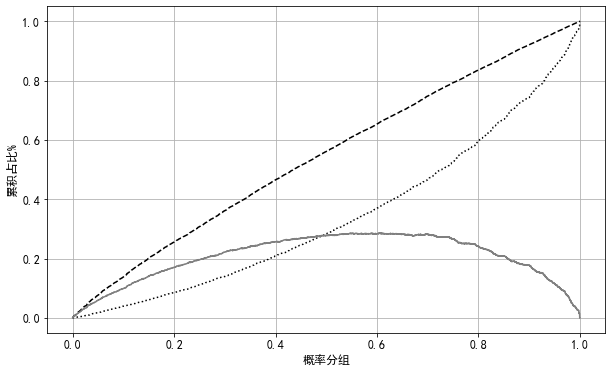

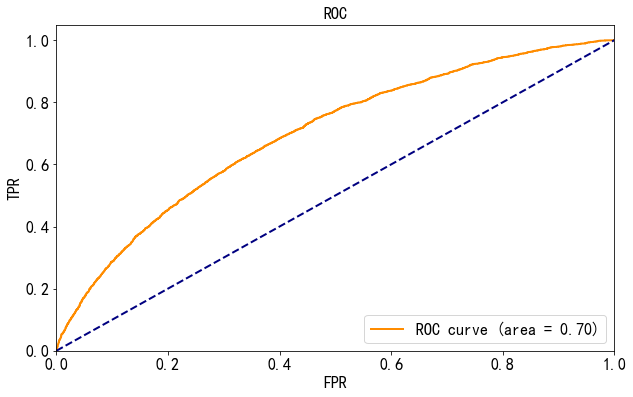

In [16]:
%matplotlib inline

####ks曲线
plt.figure(figsize=(10,6))
fontsize_1 = 12
plt.plot(np.linspace(0,1,len(tpr)),tpr,'--',color='black')
plt.plot(np.linspace(0,1,len(tpr)),fpr,':',color='black')
plt.plot(np.linspace(0,1,len(tpr)),tpr - fpr,'-',color='grey')
plt.grid()
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.xlabel('概率分组',fontsize=fontsize_1)
plt.ylabel('累积占比%',fontsize=fontsize_1)

####ROC曲线
plt.figure(figsize=(10,6))
lw = 2
fontsize_1 = 16
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks( fontsize=fontsize_1)
plt.yticks( fontsize=fontsize_1)
plt.xlabel('FPR',fontsize=fontsize_1)
plt.ylabel('TPR',fontsize=fontsize_1)
plt.title('ROC',fontsize=fontsize_1)
plt.legend(loc="lower right",fontsize=fontsize_1)

plt.show()

In [17]:
#########################
####评分卡生成
###保存模型的参数用于计算评分
var_woe_name.append('intercept')
##提取权重
weight_value = list(LR_model_fit.coef_.flatten())
##提取截距项
weight_value.extend(list(LR_model_fit.intercept_))
dict_params = dict(zip(var_woe_name,weight_value))


##查看训练集、验证集与测试集
y_score_train = LR_model_fit.predict_proba(x_train)[:, 1]
y_score_test = LR_model_fit.predict_proba(x_test)[:, 1]


####生成评分卡
df_score,dict_bin_score,params_A,params_B,score_base = create_score(dict_woe_map,dict_params,dict_cont_bin,dict_disc_bin)

##计算样本评分
df_all = pd.concat([data_train,data_test],axis = 0)
df_all_score = cal_score(df_all,dict_bin_score,dict_cont_bin,dict_disc_bin,score_base)
df_all_score.score.max()
df_all_score.score.min()
df_all_score.score[df_all_score.score >900] = 900

##简单的分数区间计算
good_total = sum(df_all_score.target == 0)
bad_total = sum(df_all_score.target == 1)
score_bin = np.arange(300,950,50)
bin_rate = []
bad_rate = []
ks = []
good_num = []
bad_num = []
for i in range(len(score_bin)-1):
    ##取出分数区间的样本
    if score_bin[i+1] == 900:
        index_1 = (df_all_score.score >= score_bin[i]) & (df_all_score.score <= score_bin[i+1]) 
    else:
        index_1 = (df_all_score.score >= score_bin[i]) & (df_all_score.score < score_bin[i+1]) 
    df_temp = df_all_score.loc[index_1,['target','score']]
    ##计算该分数区间的指标
    good_num.append(sum(df_temp.target==0))
    bad_num.append(sum(df_temp.target==1))
    ##区间样本率
    bin_rate.append(df_temp.shape[0]/df_all_score.shape[0]*100)
    ##坏样本率
    bad_rate.append(df_temp.target.sum()/df_temp.shape[0]*100)
    ##以该分数为注入分数的ks值
    ks.append(sum(bad_num[0:i+1])/bad_total - sum(good_num[0:i+1])/good_total )


df_result = pd.DataFrame({'good_num':good_num,'bad_num':bad_num,'bin_rate':bin_rate,
                         'bad_rate':bad_rate,'ks':ks}) 
print(df_result)


    good_num  bad_num   bin_rate   bad_rate        ks
0          0        0   0.000000        NaN  0.000000
1          0        0   0.000000        NaN  0.000000
2       5380     3806   9.204409  41.432615  0.144301
3      61398    13486  75.034068  18.009188  0.137375
4      14881      817  15.729459   5.204485  0.000324
5         31        1   0.032064   3.125000  0.000000
6          0        0   0.000000        NaN  0.000000
7          0        0   0.000000        NaN  0.000000
8          0        0   0.000000        NaN  0.000000
9          0        0   0.000000        NaN  0.000000
10         0        0   0.000000        NaN  0.000000
11         0        0   0.000000        NaN  0.000000
